The Kentucky Derby is on Saturday, and a field of 20 horses is slated to run “the fastest two minutes in sports” in pursuit of the right to be draped with a blanket of roses. But let’s consider, instead, the Lucky Derby, where things are a little more bizarre:

The bugle sounds, and 20 horses make their way to the starting gate for the first annual Lucky Derby. These horses, all trained at the mysterious Riddler Stables, are special. Each second, every Riddler-trained horse takes one step. Each step is exactly one meter long. But what these horses exhibit in precision, they lack in sense of direction. Most of the time, their steps are forward (toward the finish line) but the rest of the time they are backward (away from the finish line). As an avid fan of the Lucky Derby, you’ve done exhaustive research on these 20 competitors. You know that Horse One goes forward 52 percent of the time, Horse Two 54 percent of the time, Horse Three 56 percent, and so on, up to the favorite filly, Horse Twenty, who steps forward 90 percent of the time. The horses’ steps are taken independently of one another, and the finish line is 200 meters from the starting gate.

Handicap this race and place your bets! In other words, what are the odds (a percentage is fine) that each horse wins?

Extra credit: Animate this derby. I’ll broadcast the highlights next week.

In [1]:
import random
from matplotlib import pyplot as plt
from matplotlib import rc, animation
from matplotlib.ticker import FuncFormatter, MultipleLocator
import matplotlib.cm as cm
import matplotlib.colors as col
import itertools
from IPython.display import HTML
import numpy as np
from sympy import symbols, hyper,Sum, init_printing, lambdify, Function
from sympy.utilities.lambdify import implemented_function
from sympy.physics.vector import vlatex
from scipy.stats import binom as scipy_binom
from scipy.stats import mvn

init_printing(latex_printer=vlatex, latex_mode='equation')

rc('animation', html='html5')

In [2]:
def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [3]:
def format_time(time):
    m, s = divmod(int(time), 60)
    min_text = "   "
    
    if m > 0:
        min_text = "{0:>2d}m".format(m)
        
    return "{0} {1:>2d}s".format(min_text,s)

In [4]:
class Horse:
    step = 1
    
    def __init__(self, forward_prob):
        self.forward_prob = forward_prob
        self.position = 0
        self.finished = False
        
    def take_step(self, race_distance):
        if not self.finished:
            if random.random() < self.forward_prob:
                self.position += self.step
                if self.position >= race_distance:
                    self.position = race_distance
                    self.finished = True
            else:
                self.position -= self.step
        
        return self.position

In [9]:
class Race:
    
    def __init__(self, horse_forward_probs, distance):
        self.distance = distance
        self.horses = [Horse(forward_prob) for forward_prob in horse_forward_probs]
        
    def run_race(self):
        self.results = [[0 for _ in self.horses]]
        while not all([h.finished for h in self.horses]):
            self.results.append([h.take_step(self.distance) for h in self.horses])
        
    def results_by_time(self):
        return iter(self.results)
        
    def results_by_horse(self):
        return zip(*self.results)
        
    def race_time(self):
        return len(self.results)

    def num_horses(self):
        return len(self.horses)
    
    def horse_probabilities(self):
        return [h.forward_prob for h in self.horses]
    
    def horse_indices(self):
        return range(self.num_horses())

In [10]:
HORSE_FORWARD_PROBS = [.5 + .02*i for i in range(1, 21)]
DISTANCE = 200

In [27]:
derby = Race(HORSE_FORWARD_PROBS,DISTANCE)
derby.run_race()

In [28]:
CMAP = cm.ScalarMappable(col.Normalize(0, derby.num_horses()), cm.rainbow)

In [29]:
def plot_positions(race, cmap):
    fig, ax = plt.subplots(figsize=(12, 8))

    for i, h in enumerate(race.results_by_horse()):
        ax.plot(h, color=cmap.to_rgba(i), linewidth=1)

    ymin,ymax = ax.get_ylim()
    ax.set_ylim(ymin, race.distance)
    ax.set_xlim(0, race.race_time())

    ax.xaxis.set_major_locator(MultipleLocator(600))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: int(x/60)))
    
    ax.set_title("Horse Position vs. Time")
    ax.set_xlabel("Time [min]")
    ax.set_ylabel("Position [m]")
    
    plt.show()

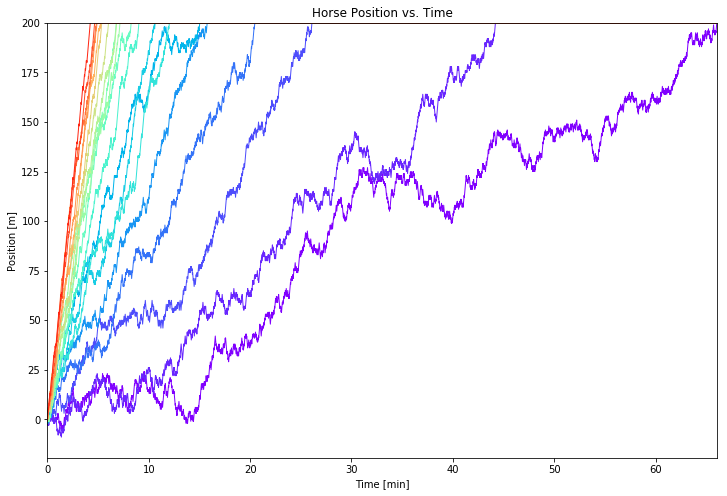

In [30]:
plot_positions(derby, CMAP)

In [31]:
def plot_finish_times(race, cmap):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.set_xlim([-0.5, race.num_horses()-0.5])
    ax.set_xticks(race.horse_indices())
    ax.xaxis.set_ticklabels(["{:<2.0f}".format(p*100) for p in race.horse_probabilities()])
    
    ax.yaxis.set_major_locator(MultipleLocator(600))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: int(x/60)))
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    ax.grid(b=True, which='major', axis='y', linestyle='--')
    
    for i, h in enumerate(race.results_by_horse()):
        ax.bar(i,
               h.index(race.distance),
               edgecolor='black',
               linewidth=2,
               color=cmap.to_rgba(i),
               zorder=10)
        
    ax.set_title("Simulated Finish Time vs. Odds Horse Advances")
    ax.set_xlabel("Odds Horse Advances [%]")
    ax.set_ylabel("Finish Time [min]")
    
    plt.show()

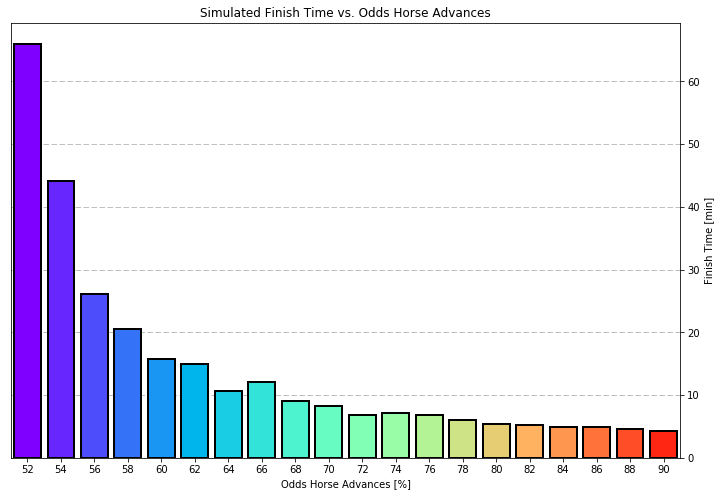

In [32]:
plot_finish_times(derby, CMAP)

In [33]:
def create_axes(race, cmap):
    xmin = min(min(r) for r in race.results)
    
    fig, ax = plt.subplots(figsize=(10, race.num_horses()/5))
    ax.axvline(color="white")
    
    overall_time = ax.text(35, race.num_horses()*(5/6), "", 
                           color="white",
                           verticalalignment='center',
                           horizontalalignment='right',
                           family='monospace',
                           size='xx-large')
    
    dots = []
    finish_times = []
    for i in race.horse_indices():
        dot = ax.plot([], 
                      [] ,
                      'o', 
                      markersize=10,
                      color=cmap.to_rgba(i))
        time = ax.text(race.distance-5, i+0.5, "", 
                       color="white",
                       verticalalignment='center',
                       horizontalalignment='right',
                       family='monospace',
                       size='large')
        dots.append(dot[0])
        finish_times.append(time)
    
    
    
    ax.set_facecolor('#573B0C')
    ax.set_position([0, 0, 1, 1])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off')
    ax.set_xlim([xmin, race.distance])
    ax.set_ylim([0, race.num_horses()])
    return fig, dots, finish_times, overall_time

In [34]:
def update_axes(frame_num, dots_gen, fig, dots, finish_times, overall_time, race):
    next_dot_positions = next(dots_gen)
    for i, (dot, next_pos, finish) in enumerate(zip(dots, next_dot_positions, finish_times)):
        dot.set_xdata(next_pos)
        dot.set_ydata(i+0.5)
        if next_pos >= race.distance and finish.get_text() == "":
            finish.set_text(format_time(frame_num))
    overall_time.set_text(format_time(frame_num))
    return fig, dots, finish_times, overall_time

In [35]:
def create_animation(race, cmap, frames=None, delay_frames=None):
    if delay_frames is None:
        delay_frames = 250
    
    positions = race.results + delay_frames*[race.results[-1]]
    dots_gen = itertools.cycle(positions)
    
    if frames is None:
        frames = len(positions)
        
    fig, dots, finish_times, overall_time = create_axes(race, cmap)
    line_ani = animation.FuncAnimation(fig,
                                       update_axes,
                                       frames=frames,
                                       fargs=(dots_gen,
                                              fig, dots,
                                              finish_times,
                                              overall_time,
                                              race),
                                       repeat=True,
                                       interval=50,
                                       save_count=frames)

    return line_ani

In [36]:
derby_anim = create_animation(derby, CMAP)
derby_anim.save("derby_animation.gif", writer="imagemagick", fps=24)
derby_anim

In [37]:
plt.close()

https://vtechworks.lib.vt.edu/bitstream/handle/10919/37928/LD5655.V856_1968.D4.pdf?sequence=1&isAllowed=y

[binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution):
The probability of getting exactly $k$ successes in $n$ trials, with $p$ probability of success is:
$$f(k;n,p) = \binom n k  p^k(1-p)^{n-k}$$

[negative binomial distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution)
the number of $n$ trials that occur for a given number of $k$ successes, , with $p$ probability of success is:
$$f(k;n,p) = \binom{n-1}{k-1} p^k(1-p)^{n-k}$$

> Probabilistically speaking, we interpret the formulas for one or more of the particles winning as the product of: the probabilities of one or more of the particles reaching the origin exactly at the $k^{th}$ trial (i.e. the negative binomial distribution); and the probability of there being less than the required number of successes or steps for the other walks to reach the origin in $k$ trials (i.e. distribution function of the binomial distribution). This product is then summed over all trials, $k$.

For example, in a race with 3 horses, starting at different distances away from the starting line, ($A$, $B$, $C$), and with different forward probabilities of ($\alpha$,$\beta$,$\gamma$),  the probability of horse $A$ winning on the exactly the $k^{th}$ trial when horses $B$ and $C$ are in positions $j$ and $l$ respectively is:

$$
p[0,j,l;k] = {{k-1}\choose{A-1}} \alpha^{A} (1-\alpha)^{k-A} {{k}\choose{B-j}} \beta^{B-j}(1-\beta)^{k-B+j}{{k}\choose{C-l}}\gamma^{C-l}(1-\gamma)^{k-C+l}
$$
$$(j>0)$$
$$(l>0)$$

So to find the overall probability of horse $A$ winning outright, we must calculate this probability over all trials.  Because it is impossible for horse $A$ to win in fewer than $A$ time steps (best case scenario is when it moves forward each step, reaching the end in $A$ steps), we can start the limit there:

$$
p[0,j,l] = \sum_{k=A}^{\infty}{{k-1}\choose{A-1}} \alpha^{A} (1-\alpha)^{k-A} {{k}\choose{B-j}} \beta^{B-j}(1-\beta)^{k-B+j}{{k}\choose{C-l}}\gamma^{C-l}(1-\gamma)^{k-C+l}
$$
$$(j>0)$$
$$(l>0)$$

and for each trial, we must sum over all possible positions of the other horses, $j$ and $l$.
$$
p[0,j,l] = \sum_{k=A}^{\infty}{{k-1}\choose{A-1}} \alpha^{A} (1-\alpha)^{k-A} \sum_{j=1}^{\infty}{{k}\choose{B-j}} \beta^{B-j}(1-\beta)^{k-B+j}\sum_{l=1}^{\infty}{{k}\choose{C-l}}\gamma^{C-l}(1-\gamma)^{k-C+l}
$$
$$(j>0)$$
$$(l>0)$$

substituting $y=B-j$ and $z=C-l$ yields:
$$
P_A = \sum_{k=A}^{\infty}{{k-1}\choose{A-1}} \alpha^{A} (1-\alpha)^{k-A} \sum_{y=0}^{\infty}{{k}\choose{y}} \beta^{y}(1-\beta)^{k-y}\sum_{z=0}^{\infty}{{k}\choose{z}}\gamma^{z}(1-\gamma)^{k-z}
$$

This can be further simplified by using the [generalized hypergeometric function](https://en.wikipedia.org/wiki/Generalized_hypergeometric_function):

$${{}_{3}F_{2}\left(\begin{matrix} a_1,\ldots,a_p \\ b_1,\ldots,b_q \end{matrix}\middle| {z} \right)}= \sum_{n=0}^\infty \frac{(a_1)_n\cdots(a_p)_n}{(b_1)_n\cdots(b_q)_n} \, \frac {z^n} {n!}$$
$$
P_A = \alpha^{A}\sum_{y=0}^{\infty}{{A}\choose{y}} \beta^{y}(1-\beta)^{A-y}\sum_{z=0}^{\infty}{{A}\choose{z}}\gamma^{z}(1-\gamma)^{A-z} {{}_{3}F_{2}\left(\begin{matrix} A, A + 1, A + 1 \\ A - y + 1, A - z + 1 \end{matrix}\middle| {\left(- \alpha + 1\right) \left(- \beta + 1\right) \left(- \gamma + 1\right)} \right)}$$

NOTE:

In the original derivation of these probability distributions, it was assumed that the racers could only either stop or move forward.  This doesn't exactly line up with the parameters of this problem because the riddle allows for backwards motion.  I've chosen to keep those bounds on the sums because:
1. I'm don't know how to modify these equations to suit that, and
2. the impact of those odds on the end results would be minimal

In [38]:
b = implemented_function(Function('binom'), scipy_binom.pmf)

In [39]:
def symbolic_win_odds(num_horses, sim_finishers_indices):
    assert len(sim_finishers_indices) >= 1 # need one winner
    assert len(sim_finishers_indices) == len(set(sim_finishers_indices)) # no duplicates
    assert len(sim_finishers_indices) <= num_horses # can't have more winners than horses

    start_pos_syms = symbols('A:{}'.format(chr(ord('A') + num_horses - 1)))
    last_start_sym_indx = max(sim_finishers_indices)
    last_start_sym = start_pos_syms[last_start_sym_indx]
    horse_probs_syms = symbols('p:{}'.format(num_horses))
    lim_vars = symbols('x:{}'.format(num_horses))
    L = symbols('L')

    
    hyper_func = hyper([last_start_sym if i in sim_finishers_indices else last_start_sym+1 for i,prob in enumerate(horse_probs_syms)],
                       [last_start_sym-sym+1 if i in sim_finishers_indices else last_start_sym-var+1 for i,(var,sym) in enumerate(zip(lim_vars, start_pos_syms)) if sym != last_start_sym],
                       np.prod([(1-prob) for prob in horse_probs_syms]))
    
    result = hyper_func
    
    for i, (lim_var, start_pos_sym, horse_probs_sym) in enumerate(zip(lim_vars, start_pos_syms, horse_probs_syms)):
        if i in sim_finishers_indices:
            result = horse_probs_sym**start_pos_sym * result
        else:
            result = Sum(b(lim_var,start_pos_sym, horse_probs_sym)*result,(lim_var,0,start_pos_sym))
    
    for sym in start_pos_syms:
        result = result.subs(sym, L)
    
    return result, (*horse_probs_syms, L)

In [40]:
eq, syms = symbolic_win_odds(2, [0])
eq

  L                                                                
 ____                                                              
 ╲                                                                 
  ╲      L                   ┌─  ⎛ L, L + 1  │                    ⎞
   ╲   p₀ ⋅binom(x₁, L, p₁)⋅ ├─  ⎜           │ (-p₀ + 1)⋅(-p₁ + 1)⎟
   ╱                        2╵ 1 ⎝L - x₁ + 1 │                    ⎠
  ╱                                                                
 ╱                                                                 
 ‾‾‾‾                                                              
x₁ = 0                                                             

In [41]:
def winner_probability(horse_odds, sim_finishers_indices, distance):
    sym_equation, sym_vars = symbolic_win_odds(len(horse_odds), sim_finishers_indices)
    func_equation = lambdify(sym_vars, sym_equation)
    return float(func_equation(*horse_odds, distance))

In [42]:
%%time
winner_probability([0.86, 0.84], [0], DISTANCE)

CPU times: user 67.7 ms, sys: 7.78 ms, total: 75.5 ms
Wall time: 120 ms


Computing these exactly is very computationally expensive, so let's opt for an approximation instead.  Each of the horses can be modeled.

> Let $x$ be the random variable representing the total amount of time required for the $i^{th}$ random walk to reach the origin independently of the other walks.

$$x = \sum_{j=1}^{A} t_j$$

> Since each $x$ is the sum of independent, identically distributed random variables, each possessing finite mean and variance, we know that the mean of $x$ will simply be the sum of means and its variance the sum of the of the $t_j$ involved.  Each $x$  will tend to be normally distributed with mean $\mu$ and variance $\sigma^2$



$$x \smallfrown N(\mu , \sigma^2)$$

In [51]:
def plot_pmfs(race, cmap):
    fig, ax = plt.subplots(figsize=(12, 8))
       
    ns = range(190,450)
    
    for i, prob in enumerate(race.horse_probabilities()):
        ax.axvline(DISTANCE/prob, color='black', zorder=-100)
        ax.bar(ns,
               [scipy_binom.pmf(race.distance, n, prob) for n in ns],
               width=1,
               color=cmap.to_rgba(i),
               zorder=-i)
    
    plt.show()

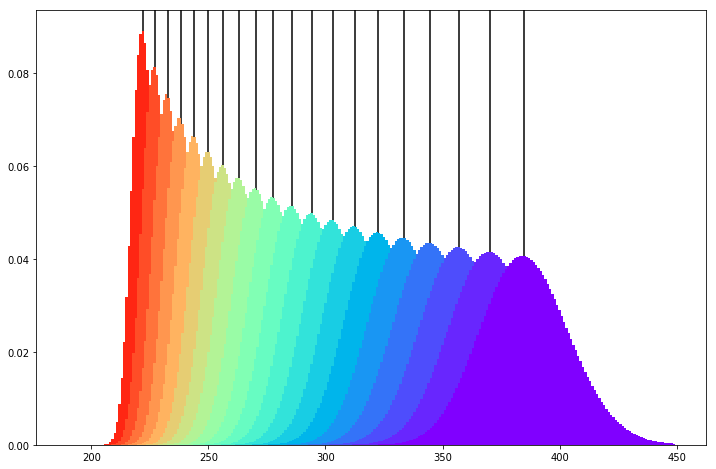

In [44]:
plot_pmfs(derby, CMAP)

Now let's create a distribution for each horse:

$$\underline{x} = \begin{bmatrix} 
x_1 \\ 
x_2 \\ 
x_3 \\ 
\vdots \\
x_n \\ 
\end{bmatrix},
\underline{\mu} = \begin{bmatrix} 
\mu_1 \\ 
\mu_2 \\ 
\mu_3 \\ 
\vdots \\
\mu_n \\ 
\end{bmatrix},
\underline{\sigma}= \begin{bmatrix} 
\sigma_1^2 & 0 & 0 & \ldots & 0 \\ 
0 & \sigma_2^2 & 0 & \ldots & 0 \\ 
\ldots & \ldots & \ldots & \ldots & \ldots \\ 
0 & 0 & 0 & \ldots & \sigma_n^2 \\ 
\end{bmatrix}$$

$$y = \begin{bmatrix} 
y_1 \\ 
y_2 \\
\vdots \\
y_{n-1}
\end{bmatrix}
=
\begin{bmatrix} 
x_1 - x_2 \\ 
x_1 - x_3 \\ 
\vdots \\
x_1 - x_n
\end{bmatrix}$$
and
$$
T = \begin{bmatrix} 
1 & -1 & 0 & \ldots & 0 \\ 
1 & 0 & -1 & \ldots & 0 \\ 
\vdots & \vdots & \vdots & \ddots & \vdots \\ 
1 & 0 & 0 & \ldots & -1 \\ 
\end{bmatrix}
$$

$$y \smallfrown N_{n-1}(T\mu , T\Sigma T')$$

$$T\mu = \begin{bmatrix} 
\mu_1 - \mu_2 \\ 
\mu_1 - \mu_3 \\ 
\mu_1 - \mu_4 \\ 
\ldots \\
\mu_1 - \mu_n \\ 
\end{bmatrix}$$

$$T \Sigma T'= \begin{bmatrix} 
(\sigma_1^2 + \sigma_2^2) & \sigma_1^2 & \sigma_1^2 & \ldots & \sigma_1^2 \\ 
\sigma_1^2 & (\sigma_1^2 + \sigma_3^2) & \sigma_1^2 & \ldots & \sigma_1^2 \\ 
\vdots & \vdots & \vdots & \ddots & \vdots \\ 
\sigma_1^2 & \sigma_1^2 & \sigma_1^2 & \ldots & (\sigma_1^2 + \sigma_n^2) \\ 
\end{bmatrix}(n-1)\times(n-1)$$

For 3 horses only:

$$T\mu = \begin{bmatrix} 
\mu_1 - \mu_2 \\ 
\mu_1 - \mu_3 \\ 
\end{bmatrix}$$

$$T \Sigma T'= \begin{bmatrix} 
(\sigma_1^2 + \sigma_2^2) & \sigma_1^2 \\ 
\sigma_1^2 & (\sigma_1^2 + \sigma_3^2) \\ 
\end{bmatrix}$$

$$y = \begin{bmatrix} 
y_1 \\ 
y_2 \\ 
\end{bmatrix}
=
\begin{bmatrix} 
x_1 - x_2 \\ 
x_1 - x_3 \\ 
\end{bmatrix}
\leq
\begin{bmatrix} 
\frac{1}{2} \\ 
\frac{1}{2} \\ 
\end{bmatrix}
$$

This is $\leq \frac{1}{2}$ because of the possibility of ties in the discrete case

$$\mu_1 = \frac{L}{\alpha}, \sigma_1^2 = \frac{L(1-\alpha)}{\alpha^2}$$
$$\mu_2 = \frac{L}{\beta}, \sigma_2^2 = \frac{L(1-\beta)}{\beta^2}$$
$$\mu_3 = \frac{L}{\gamma}, \sigma_3^2 = \frac{L(1-\gamma)}{\gamma^2}$$

$$y_1 \smallfrown N\left[\left(\frac{L}{\alpha}-\frac{L}{\beta}\right) , \left(\frac{L(1-\alpha)}{\alpha^2} + \frac{L(1-\beta)}{\beta^2}\right)\right]$$
$$y_2 \smallfrown N\left[\left(\frac{L}{\alpha}-\frac{L}{\gamma}\right) , \left(\frac{L(1-\alpha)}{\alpha^2} + \frac{L(1-\gamma)}{\gamma^2}\right)\right]$$

In [45]:
def calc_var(L, prob):
    return (L * (1-prob))/(prob**2)

In [46]:
def approximate_horse_winning(race, winning_horse_index):
    winner_prob = race.horse_probabilities()[winning_horse_index]
    other_horse_probs = [prob for i,prob in enumerate(race.horse_probabilities()) 
                         if i != winning_horse_index]
    num_loser_horses = race.num_horses() -1 
    
    mus = np.array([DISTANCE/winner_prob - DISTANCE/prob for prob in other_horse_probs])
                         
    covar = calc_var(DISTANCE, winner_prob) * np.ones((num_loser_horses,num_loser_horses))

    covar[np.diag_indices_from(covar)] += [calc_var(DISTANCE, prob)
                                           for prob in other_horse_probs]
                                                   
    low = -500 * np.ones(num_loser_horses)
    upp = 0.5 * np.ones(num_loser_horses)
                                                   
    p,i = mvn.mvnun(low,upp,mus,covar)
    
    return p                                          

In [47]:
win_probs = [approximate_horse_winning(derby, i) for i in derby.horse_indices()]    

In [48]:
for i,prob in enumerate(win_probs):
    print("{0:2d} {1:.3E}".format(i, prob))

 0 1.149E-17
 1 1.365E-16
 2 1.546E-15
 3 1.779E-14
 4 1.941E-13
 5 2.126E-12
 6 2.276E-11
 7 2.346E-10
 8 2.329E-09
 9 2.219E-08
10 2.007E-07
11 1.707E-06
12 1.347E-05
13 9.714E-05
14 6.284E-04
15 3.565E-03
16 1.736E-02
17 7.138E-02
18 2.463E-01
19 7.190E-01


In [49]:
def plot_win_probs(race, win_probs, cmap):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.set_xlim([-0.5, race.num_horses()-0.5])
    ax.set_xticks(race.horse_indices())
    ax.xaxis.set_ticklabels(["{:<2.0f}".format(p*100) for p in race.horse_probabilities()])

    ax.grid(b=True, which='major', axis='y', linestyle='--')
    
    ax.set_ylim([10**-20, 10**1])
    
    for i, prob in enumerate(win_probs):
        ax.bar(i,
               prob,
               edgecolor='black',
               linewidth=2,
               color=cmap.to_rgba(i),
               zorder=10,
               log=True)
    
    ax.set_title("Overall Win Probability vs. Odds Horse Advances")
    ax.set_xlabel("Odds Horse Steps Forward [%]")
    ax.set_ylabel("Overall Win Probability")
    
    plt.show()

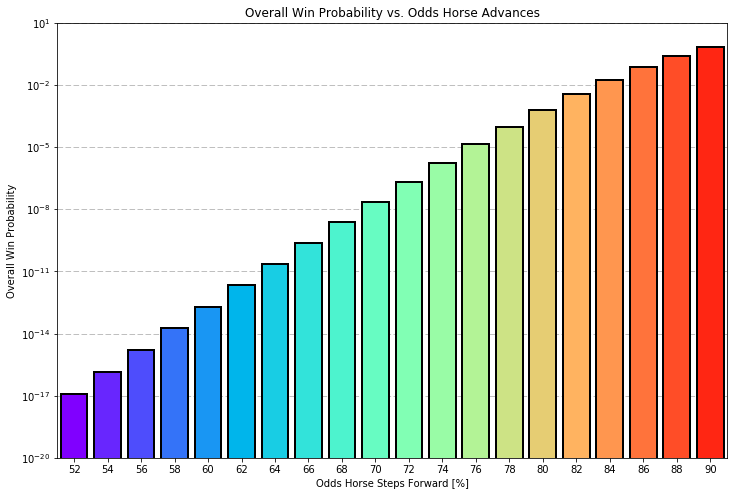

In [50]:
plot_win_probs(derby, win_probs, CMAP)